In [1]:
%load_ext autoreload
%autoreload 2
import ruamel.yaml as yaml
import os
import sys
os.chdir('..')
print(os.getcwd())
import sys
import json
import pickle
from utils.file_handling import MultiOutput, load_model_from_config
from utils.nn_utils import set_seed
from evaluation.vizualizations import tsne_plot, correlation_plot
from experiment import *
from evaluation.topics import get_topics, npmi_coherence_score, print_top_words, get_most_correlated_topics

/home/dorian/FER/master_thesis/src/base


In [2]:
MODEL_PATH = 'results/beer/HFVAE/2020-06-21-16:42/'
SAVE_PATH = MODEL_PATH
config_path = os.path.join(MODEL_PATH, 'config.yaml')
config = yaml.safe_load(open(config_path, 'r'))
data_path = config['experiment_parameters']['data_path']
model = load_model_from_config(config_path, weights_path=os.path.join(MODEL_PATH, 'model.pt'))
model.eval()
experiment = experiments[config['experiment_parameters']['name']](model, config['experiment_parameters'])
set_seed(config['experiment_parameters']['seed'])

#### TSNE

In [ ]:
zs, z_mus = experiment.sample_latent(experiment.test_dataloader())
ys = np.load(os.path.join(data_path, 'test.labels.npy'))[:zs.shape[0]]
# labels = json.load(open(os.path.join(data_path, 'labels.json'), 'r'))
xs = np.load(os.path.join(data_path, 'test.npy'))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 7000 but corresponding boolean dimension is 7221

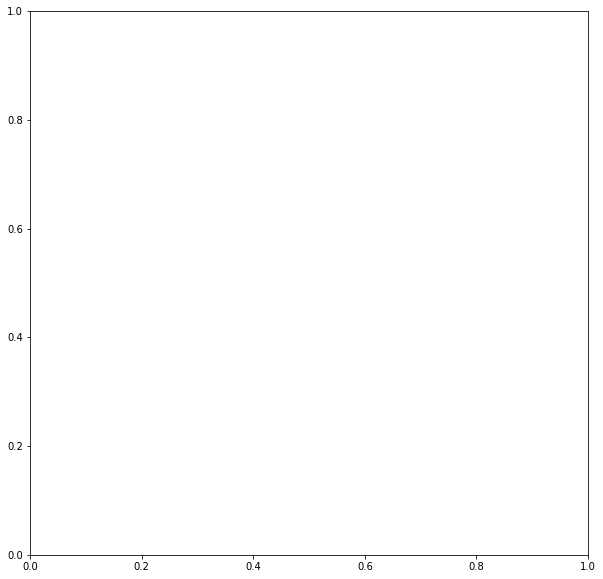

In [18]:
tsne_plot(z_mus, ys, labels, show=True, save_path=SAVE_PATH, plot_by_class=True,
          perplexity=5, learning_rate=200, n_iter=3000, n_jobs=-1)

#### Correlation plot

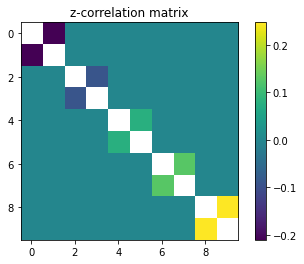

In [11]:
correlation_plot(zs, show=True, save_path=SAVE_PATH)
#correlation_plot(zs, show=True, save_path=None, cutoff=0.06)

#### Topics

In [12]:
n_top = 10
vocab = json.load(open(os.path.join(data_path, 'vocab.json'), 'r'))
idx2word = {i: vocab[i] for i in range(len(vocab))}
beta = model.decoder.main[0].weight.cpu().detach().numpy().T
topics = get_topics(beta, idx2word, n_top=n_top)
print_top_words(beta, idx2word, n_top=n_top, save_path=os.path.join(SAVE_PATH, 'topics.txt'))



--------------- Topics ------------------
pallette motif tulip amen coach frutiness schlitz pellucid chicagoland changeup
lopsided disappointing accessory put honorable prominent graininess bizarrely backyard exclaim
leavenworth weissebier palisade colar exclusion frambozen characterstic terror descend zeus
carboration patricks eggnog annoy toledo technically nectarine offsetting beere nutritional
bitting ratio energetic flying miss reminiscence expecting bangkok downer chilled
perennial nectarine hire cheapness abruptly blame conquer eggnog cloak collide
liqour mediu excellence albuquerque petrus menagerie perceptibly induce odour konig
calling bismol neigh force artwork maize pickin wipeout wail speedy
badger similar artist nashua admission impresive supremacy artwork resource queer
exclaim approx fd put barely telegraph locker platinum widespread itch
-----------------------------------------


#### NPMI

In [13]:
word_frequencies = pickle.load(open(os.path.join(data_path, 'word_frequencies.pkl'), 'rb'))
joint_word_frequencies = pickle.load(open(os.path.join(data_path, 'jointword_frequencies.pkl'), 'rb'))
npmi_per_topic = npmi_coherence_score(topics, word_frequencies, joint_word_frequencies)
print(npmi_per_topic)
print(sum(npmi_per_topic) / len(npmi_per_topic))
print('Max: %f' % max(npmi_per_topic))
print('Topic : %s' % (' '.join(topics[np.argmax(npmi_per_topic)])))
# save results
json.dump({'npmi_per_topic': npmi_per_topic, 'avg_npmi': sum(npmi_per_topic) / len(npmi_per_topic),
           'topics': topics},
          open(os.path.join(SAVE_PATH, 'npmi.json'), 'w'), indent=4)

[-0.7805123905616117, -0.5241849809905724, -1.0, -1.0, -0.8536089850369699, -0.9477468771419149, -0.9124211193513261, -0.9268559683516234, -0.8137947471253111, -0.7423281308577739]
-0.8501453199417103
Max: -0.524185
Topic : lopsided disappointing accessory put honorable prominent graininess bizarrely backyard exclaim


In [7]:
z_mean_activations = z_mus.mean(axis=0)

In [8]:
show_topics = []
for i, topic in enumerate(topics):
    show_topics.append({'words':' '.join(topic), 'npmi':npmi_per_topic[i], 'z_activation':z_mean_activations[i]})
show_topics = sorted(show_topics, key=lambda topic: -topic['npmi'])
json.dump(show_topics, open(os.path.join(SAVE_PATH, 'show_topics.json'),'w'), indent=4)

In [26]:
act_mi = [(act, mi) for act, mi in zip(z_mean_activations, npmi_per_topic)]
act_mi = sorted(act_mi, key=lambda tup: -tup[0])

#### Most correlated topics

In [8]:
inds, covs, cor_topics = get_most_correlated_topics(np.corrcoef(zs.T), top_correlations=4)
print(inds)
print(covs)
for topic in cor_topics:
    print('%d %f %s' % (topic, npmi_per_topic[topic], topics[topic]))

[[ 2 21]
 [21  2]
 [21 24]
 [24 21]]
[0.20866464652092986, 0.20866464652092986, 0.22352808150566772, 0.22352808150566772]
2 0.290516 ['citizens', 'israel', 'anti', 'killed', 'americans', 'government', 'federal', 'israeli', 'drugs', 'army']
21 0.247132 ['goals', 'goal', 'period', 'time', 'gave', 'part', 'show', 'make', 'year', 'led']
24 0.153905 ['truth', 'question', 'win', 'sunday', 'answer', 'true', 'atheists', 'hell', 'points', 'detroit']


#### MUTUAL INFO

In [4]:
# mutual info I(y, z)
# quantize each dimension z_d into 20 bins (20newsgroups)
# 5% of the training data into each bin of each z_d
# I(z \elem bin_i, y=k) = q(z \elem bin_i, y=k)log[(q(z \elem bin_i), y=k) / (q(z \elem bin_i) q(y=k))]

# I(z, y) = sum(l) sum(k) I(z=l, y=k)
import pandas as pd
from sklearn.feature_selection import mutual_info_classif as mutual_info
mis = np.zeros([len(labels), zs.shape[1]])
for i in range(len(labels)):
    for j in range(zs.shape[1]):
        z_bin = pd.cut(zs[:, j], 20)
        y = (ys==i).astype(int)
        mi = mutual_info(z_bin.codes.reshape(-1,1), y)
        print(mi)
        mis[i,j] = mi

[0]
[0]
[0.00117288]
[0.0008807]
[0.00303905]
[0.00119206]
[0.00102478]
[0]
[0]
[0]
[0.00469973]
[0]
[0.0001203]
[0.00360592]
[0.00166922]
[0]
[0.00246861]
[0.00201112]
[0]
[0]
[0.00202458]
[0]
[0]
[0.00012719]
[0]
[0.00234105]
[0]
[0]
[0]
[0.00075285]
[0]
[0.00509332]
[0.00364739]
[0.00355101]
[0.00335139]
[0]
[0.00252243]
[0.00199571]
[0.00192792]
[0]
[0]
[0.00161913]
[0]
[0.00036325]
[0]
[0.00301487]
[0]
[0.00085372]
[0.00046911]
[0]
[0]
[0]
[0]
[0.00120514]
[0]
[0]
[0]
[0.00054751]
[0.00030422]
[3.93589966e-05]
[0.00365194]
[0]
[0]
[0.00335297]
[0]
[0]
[0]
[0.00300368]
[0.00123407]
[0]
[0]
[0.00113032]
[0.00180389]
[0]
[0.00174995]
[0.00152746]
[0]
[0.00029196]
[0.00129557]
[0]
[0.00114365]
[0.00047007]
[0.00060157]
[0.00382593]
[0.00218886]
[0]
[0]
[0]
[0.00415399]
[0.00159973]
[0.00417197]
[0]
[0]
[0.00041222]
[0.00186132]
[0.0030239]
[0.00263211]
[0]
[0]
[0]
[0]
[0.00287721]
[0.00101474]
[0.00266006]
[0]
[0]
[0.00123531]
[0]
[4.99167386e-05]
[0.0014636]
[0]
[0.00275905]
[0.00215

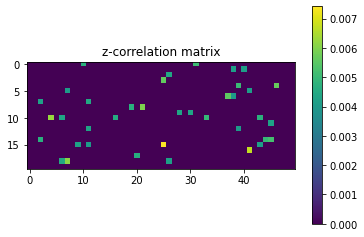

In [8]:
import matplotlib.pyplot as plt
plot_mis = mis
plot_mis[plot_mis < 0.004] = 0.0
plt.imshow(plot_mis)
plt.title('z-correlation matrix')
plt.colorbar()
plt.savefig(os.path.join(SAVE_PATH, 'I(y,z).png'))

In [ ]:
mis_x = []
for j in range(zs.shape[1]):
    z_bin = pd.cut(zs[:, j], 20)
    mi = mutual_info(xs[:z_bin.shape[0]], z_bin.codes)
    print(mi)
    mis_x.append(mi)

[0.         0.00700964 0.00798596 ... 0.00100205 0.         0.        ]
